In [ ]:
#environment setup
!pip install --quiet --upgrade tensorflow-federated

%load_ext tensorboard

import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

#download dataset
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()
emnist_train.element_type_structure




OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

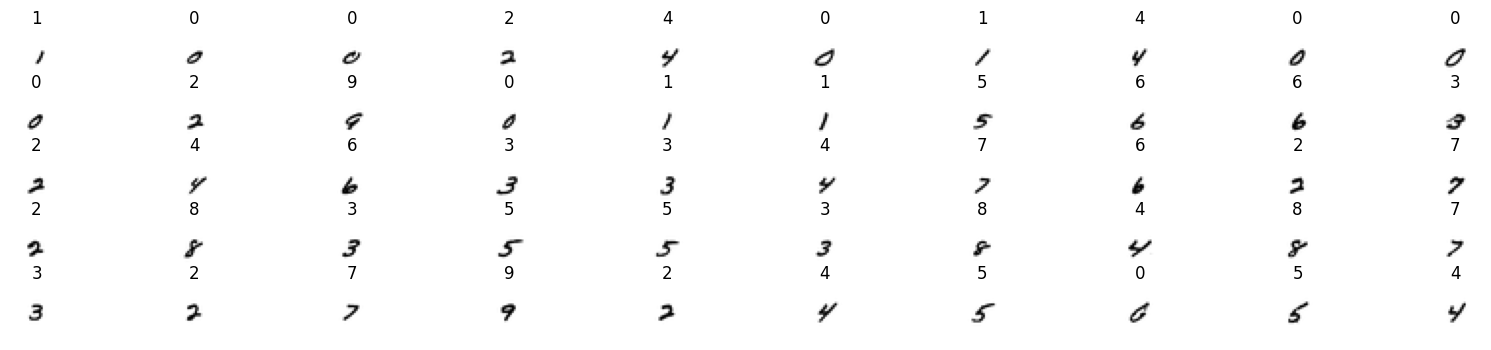

In [ ]:
#1.Prepare the input data

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[30])

example_element = next(iter(example_dataset))

example_element['label'].numpy()

# from matplotlib import pyplot as plt
# plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
# plt.grid(False)
# _ = plt.show()


## Example MNIST digits for one client
figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(50):
  plt.subplot(5, 10, j+1)
  plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.title(example['label'].numpy()) #add title
  plt.axis('off')
  j += 1



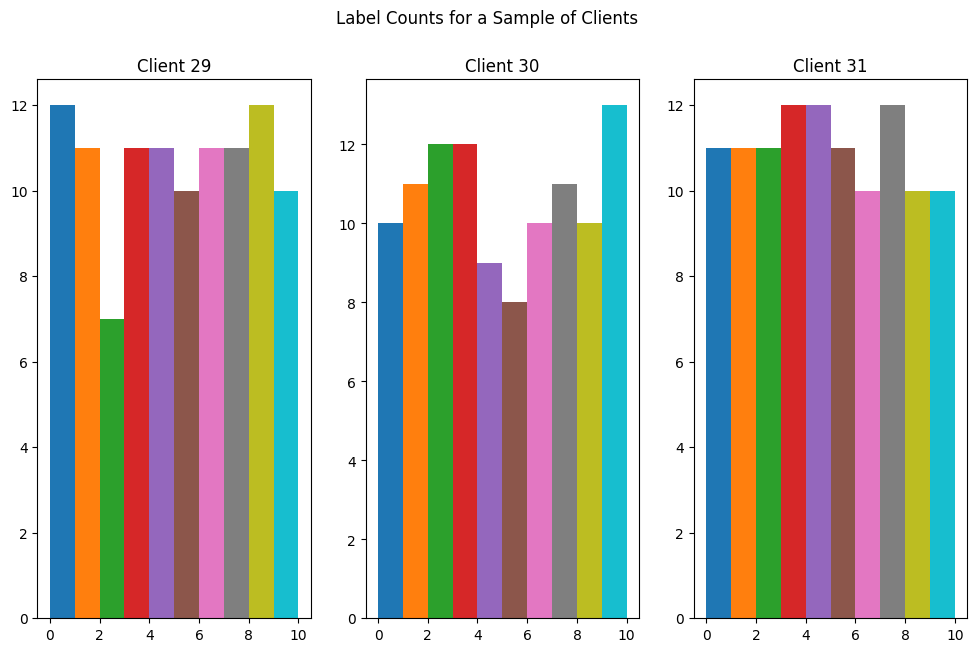

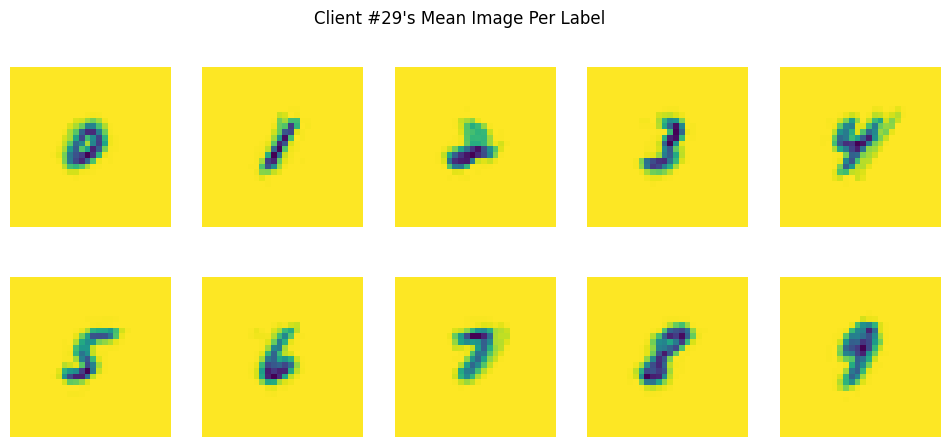

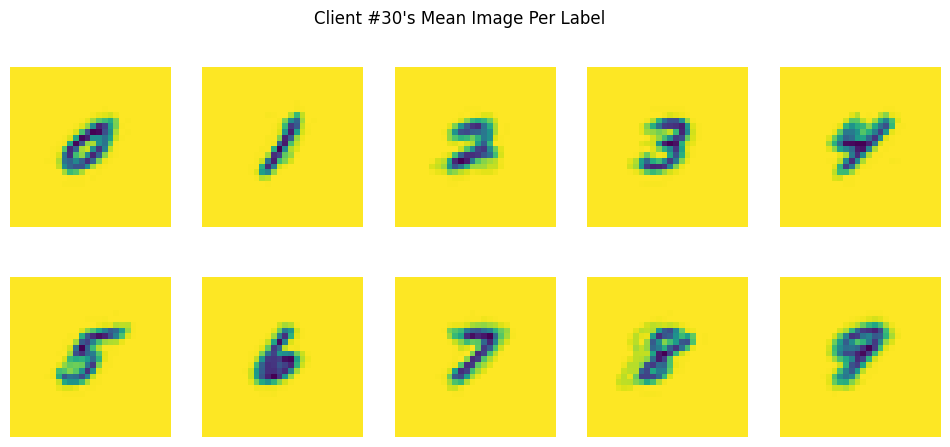

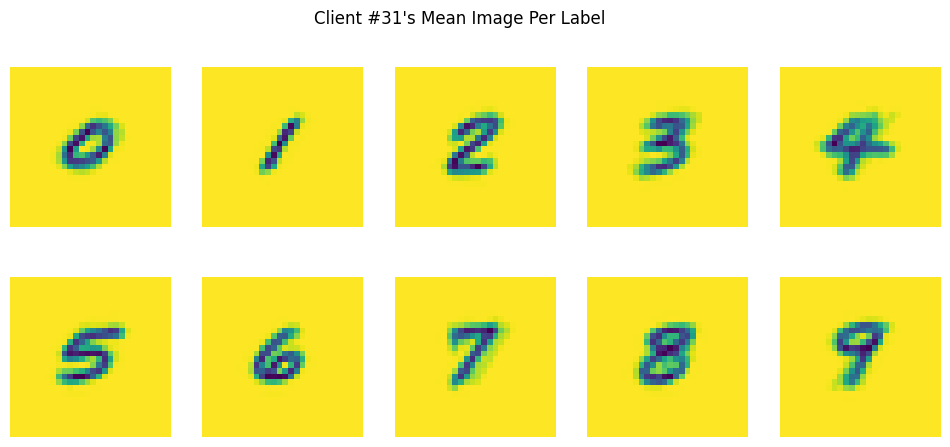

In [ ]:
#2.Exploring heterogeneity in FL

X = 30  # Replace with the last three digits of your student ID
clients_to_plot = [X-1, X, X+1]

# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(3):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[clients_to_plot[i]]) # use client 29 30 31
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(1, 3, i+1)
  plt.title('Client {}'.format(clients_to_plot[i]))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.show()

# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(3):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[clients_to_plot[i]]) #here
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i+1, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(clients_to_plot[i])) #here
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')



In [ ]:

#Process the input data
NUM_CLIENTS = 10  #need to change?
NUM_EPOCHS = 30
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

#Process the input data - Choose Clients
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

sample_clients = emnist_train.client_ids[0:NUM_CLIENTS] 
federated_train_data = make_federated_data(emnist_train, sample_clients) 
print('Number of client datasets: {l}'.format(l=len(federated_train_data))) 
print('First dataset: {d}'.format(d=federated_train_data[0]))


#Create a Model with Keras
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
#3.Training the model on federated data
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))
train_state = training_process.initialize()

# result = training_process.next(train_state, federated_train_data)
# train_state = result.state
# train_metrics = result.metrics
#print('round  1, metrics={}'.format(train_metrics))

NUM_ROUNDS = 30
for round_num in range(1, NUM_ROUNDS+1):
  result = training_process.next(train_state, federated_train_data)
  train_state = result.state
  train_metrics = result.metrics
  print('round {:2d}, metrics={}'.format(round_num, train_metrics))


Number of client datasets: 10
First dataset: <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.23710562), ('loss', 2.5479136), ('num_examples', 29160), ('num_batches', 1462)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.37640604), ('loss', 1.9500217), ('num_examples', 29160), ('num_batches', 1462)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', Order

In [ ]:
#4.Displaying model metrics in TensorBoard

logdir = "/tmp/logs/scalars/training/"
try:
  tf.io.gfile.rmtree(logdir)  # delete any previous results
except tf.errors.NotFoundError as e:
  pass # Ignore if the directory didn't previously exist.
summary_writer = tf.summary.create_file_writer(logdir)
train_state = training_process.initialize()

with summary_writer.as_default():
  for round_num in range(1, NUM_ROUNDS):
    result = training_process.next(train_state, federated_train_data)
    train_state = result.state
    train_metrics = result.metrics
    for name, value in train_metrics['client_work']['train'].items():
      tf.summary.scalar(name, value, step=round_num)
      
!ls {logdir}
%tensorboard --logdir {logdir} --port=0


events.out.tfevents.1684479937.1b6c012788d6.186397.0.v2


<IPython.core.display.Javascript object>

In [ ]:
https://medium.com/sherry-ai/%E8%81%AF%E7%9B%9F%E5%BC%8F%E5%AD%B8%E7%BF%92-federated-learning-b4cc5af7a9c0